# Predicting Whether a Breast Cancer Sample is Benign or Malignant

**Note:** This notebook was last tested with the `Python 3 (Data Science 3.0)` environment image in Amazon SageMaker Studio.

## Learning Objectives:

1. Understand what SageMaker Script Mode is, and how it can be leveraged.
1. Read in data from S3 to SageMaker
1. User prebuilt SageMaker containers to build, train, and deploy a custom sklearn model
1. Use batch transform to perform inferences and measure model performance.

## Introduction

This is a breast cancer diagnoses dataset, where, for each sample, the sample is diagnosed as "Benign" or "Malignant". For each sample, a number of features are given as well. The source of the dataset is the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+(Diagnostic)).

For this model, we will build, train and deploy a [Multi-layer Perceptron](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html) using the sklearn library.

## Setup

Ensure we have the latest version of sagemaker

In [ ]:
%pip install --disable-pip-version-check -U -q -r requirements.txt

Import required libraries and create necessary clients

In [3]:
import boto3
import matplotlib.pyplot as plt
import pandas
import sagemaker
from sagemaker.sklearn.estimator import SKLearn
from sagemaker.s3 import S3Downloader, S3Uploader
import sklearn
import sklearn.metrics as metrics
from sklearn import model_selection
import s3fs

role = sagemaker.get_execution_role()
sagemaker_session = sagemaker.Session()
BUCKET = sagemaker_session.default_bucket()
PREFIX = "breast_cancer"

## Process the Data

Download the sample data

In [4]:
S3Downloader.download(
    s3_uri="s3://sagemaker-sample-files/datasets/tabular/breast_cancer/wdbc.csv",
    local_path="data",
    sagemaker_session=sagemaker_session,
)

df_data = pandas.read_csv(
    "data/wdbc.csv",
    names=[
        "id",
        "diagnosis",
        "radius_mean",
        "texture_mean",
        "perimeter_mean",
        "area_mean",
        "smoothness_mean",
        "compactness_mean",
        "concavity_mean",
        "concave points_mean",
        "symmetry_mean",
        "fractal_dimension_mean",
        "radius_se",
        "texture_se",
        "perimeter_se",
        "area_se",
        "smoothness_se",
        "compactness_se",
        "concavity_se",
        "concave points_se",
        "symmetry_se",
        "fractal_dimension_se",
        "radius_worst",
        "texture_worst",
        "perimeter_worst",
        "area_worst",
        "smoothness_worst",
        "compactness_worst",
        "concavity_worst",
        "concave points_worst",
        "symmetry_worst",
        "fractal_dimension_worst",
    ],
)

df_data

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,...,25.380,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,...,24.990,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,...,23.570,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,...,14.910,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,...,22.540,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,926424,M,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,...,25.450,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115
565,926682,M,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,...,23.690,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637
566,926954,M,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,...,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820
567,927241,M,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,...,25.740,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400


Get the feature names for analysis

In [5]:
features = list(set(df_data.columns) - set(["id", "diagnosis"]))

One-hot encode the diagnosis column

In [6]:
df_data = pandas.get_dummies(df_data, columns=["diagnosis"])

Get the data with encoded features. Malignant is now 1, Benign is 0

In [7]:
df_data = df_data.rename(columns={"diagnosis_M": "truth"})
df_data = df_data[features + ["truth"]]

Preview the feature data frame

In [8]:
import sagemaker_datawrangler

df_data

     texture_se  perimeter_worst  smoothness_mean  fractal_dimension_mean  \
0        0.9053           184.60          0.11840                 0.07871   
1        0.7339           158.80          0.08474                 0.05667   
2        0.7869           152.50          0.10960                 0.05999   
3        1.1560            98.87          0.14250                 0.09744   
4        0.7813           152.20          0.10030                 0.05883   
..          ...              ...              ...                     ...   
564      1.2560           166.10          0.11100                 0.05623   
565      2.4630           155.00          0.09780                 0.05533   
566      1.0750           126.70          0.08455                 0.05648   
567      1.5950           184.60          0.11780                 0.07016   
568      1.4280            59.16          0.05263                 0.05884   

     concave points_worst  smoothness_se  area_se  concave points_mean  \
0

Split the data into training (70%) and test (30%) sets

In [9]:
train_df, test_df = model_selection.train_test_split(df_data, test_size=0.3)

Move the truth column to the front of the training data set

In [10]:
train_df = train_df[["truth"] + features]

Process the test data set

In [11]:
x_test = test_df[features]
y_test = test_df["truth"].tolist()
print(f"The test data has shape {x_test.shape}")

The test data has shape (171, 30)


Copy the training and test data to s3 so that sagemaker can read it


In [12]:
train_df.to_csv("data/train_data.csv", index=False)
training_data_path = S3Uploader.upload(
    local_path="data/train_data.csv",
    desired_s3_uri=f"s3://{BUCKET}/{PREFIX}",
    sagemaker_session=sagemaker_session,
)

x_test.to_csv("data/x_test.csv", index=False, header=False)
test_data_path = S3Uploader.upload(
    local_path="data/x_test.csv",
    desired_s3_uri=f"s3://{BUCKET}/{PREFIX}",
    sagemaker_session=sagemaker_session,
)

## Train the Model

Define a training script

In [13]:
%%writefile train.py

import argparse
import joblib
import numpy as np
import os
import pandas as pd
from sklearn.neural_network import MLPClassifier

if __name__ == "__main__":
    parser = argparse.ArgumentParser()

    # Sagemaker specific arguments. Defaults are set in the environment variables.
    parser.add_argument("--output-data-dir", type=str, default=os.environ.get("SM_OUTPUT_DATA_DIR"))
    parser.add_argument("--model-dir", type=str, default=os.environ.get("SM_MODEL_DIR"))
    parser.add_argument("--train", type=str, default=os.environ.get("SM_CHANNEL_TRAIN"))
    args = parser.parse_args()

    # Take the set of files and read them all into a single pandas dataframe
    train_data=pd.read_csv(os.path.join(args.train, "train_data.csv"))

    # Extract the labels from the first column
    train_y = train_data["truth"]
    train_X = train_data[train_data.columns[1:len(train_data)]]

    # Use scikit-learn's MLP Classifier to train the model.
    regr = MLPClassifier(random_state=1, max_iter=500).fit(train_X, train_y)
    regr.get_params()

    # Print the coefficients of the trained classifier, and save the coefficients
    joblib.dump(regr, os.path.join(args.model_dir, "model.joblib"))

def model_fn(model_dir):
    """Deserialized and return fitted model

    Note that this should have the same name as the serialized model in the main method
    """
    regr = joblib.load(os.path.join(model_dir, "model.joblib"))
    return regr

def predict_fn(input_data, model):
    """return the class and the probability of the class"""
    prediction = model.predict(input_data)
    pred_prob = model.predict_proba(input_data) # A numpy array
    return np.array(pred_prob)

Writing train.py


Create the estimator

In [14]:
sklearn = SKLearn(
    entry_point="train.py",
    instance_type="ml.c4.xlarge",
    role=role,
    py_version="py3",
    framework_version="0.23-1",
    sagemaker_session=sagemaker_session,
)

Kick off the training job

In [ ]:
sklearn.fit({"train": training_data_path})

## Make Batch Predictions

Set up a batch transformer for predictions


In [16]:
transformer = sklearn.transformer(
    instance_count=1, instance_type="ml.m4.xlarge", accept="text/csv"
)

Start a transform job and wait for it to finish

In [ ]:
batch_input_s3 = test_data_path
transformer.transform(batch_input_s3, content_type="text/csv", split_type="Line")
print("Waiting for transform job: " + transformer.latest_transform_job.job_name)
transformer.wait()

Download the output data from S3 to local filesystem

In [ ]:
batch_output = transformer.output_path
print(f"Batch transform results saved to {batch_output}")
S3Downloader.download(
    s3_uri=batch_output,
    local_path="data/output",
    sagemaker_session=sagemaker_session,
)

Preview the batch transform results


In [19]:
!head data/output/*

1.8619501076067024e-05,0.9999813804989239
0.7748982923220475,0.2251017076779525
0.00023643271058249038,0.9997635672894175
0.026216552229230916,0.9737834477707691
0.9713531288469958,0.02864687115300421
0.000558163154396385,0.9994418368456036
2.456845116682871e-06,0.9999975431548833
0.07064185010995883,0.9293581498900412
0.976998833444971,0.023001166555029016
1.0080723532590596e-06,0.9999989919276467


Load the predictions and measure performance

In [20]:
predictions = pandas.read_csv("data/output/x_test.csv.out", header=None)
predictions.reset_index(drop=True, inplace=True)
results = pandas.concat([predictions, pandas.Series(y_test)], axis=1)
results.columns = ["pred_0", "pred_1", "true"]
results["true"] = results["true"].astype(int)

Plot the AUC-ROC curve

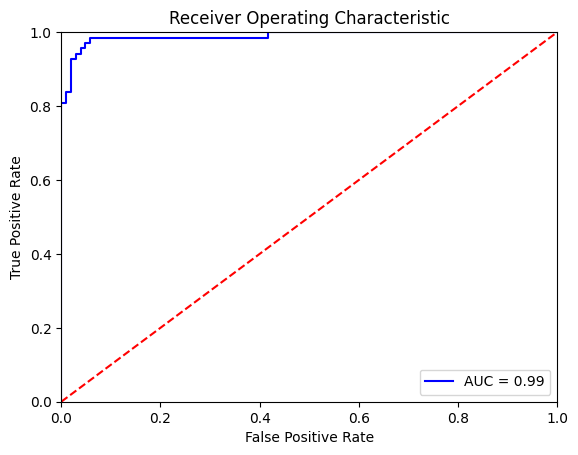

In [21]:
fpr, tpr, threshold = metrics.roc_curve(results["true"], results["pred_1"])
roc_auc = metrics.auc(fpr, tpr)

plt.title("Receiver Operating Characteristic")
plt.plot(fpr, tpr, "b", label="AUC = %0.2f" % roc_auc)
plt.legend(loc="lower right")
plt.plot([0, 1], [0, 1], "r--")
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.show()

## Clean Up

In [ ]:
import os 

# Delete model
transformer.delete_model()

# Delete local objects
import shutil
shutil.rmtree("data")
os.remove("train.py")

## Closing

In this notebook we used SageMaker script mode to build, train, and deploy a sklearn model.